# Download Funwave

Download Funwave timeseries from Napier programatically using Datamesh

In [87]:
import xarray as xr
import geopandas
import json
import geopandas
from shapely.geometry import Polygon, MultiPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from dask.diagnostics.progress import ProgressBar

from oceanum.datamesh import Connector

In [3]:
datamesh = Connector(token=None) # replace your token here

In [4]:
datasources = [
    "funwave-napier-20090830_1526",
    "funwave-napier-20110108_2057",
    "funwave-napier-20110426_0727",
    "funwave-napier-20110814_2057",
    "funwave-napier-20110817_0027",
    "funwave-napier-20110817_0927",
    "funwave-napier-20120107_2226",
    "funwave-napier-20141112_1027",
    "funwave-napier-20141119_1927",
    "funwave-napier-20170413_1027",
    "funwave-napier-20171103_2027",
    "funwave-napier-20180428_0657",
    "funwave-napier-20190625_0340",
    "funwave-napier-20190705_2240",
    "funwave-napier-20190815_0440",
    "funwave-napier-20200424_1340",
    "funwave-napier-20201109_0041",
    "funwave-napier-20210527_0711",
    "funwave-napier-20211104_0110",
    "funwave-napier-20211105_1440",
]

In [74]:
def query_dataset(datasource: str, geom: geopandas.GeoSeries) -> xr.Dataset:
    """Query data from datamesh.

    Parameters
    ----------
    datasource : str
        The Datamesh id of the datasource to query.
    geom : geopandas.GeoSeries
        GeoSeries object with the geometry to query, only single geometry supported.

    Returns
    -------
    dset: xr.Dataset
        The queried dataset.

    """
    query = {
        "datasource": datasource,
        "variables": ["dep.out", "u", "v", "eta"],
        "geofilter": {
            "type": "feature",
            "geom": json.loads(geom.to_json())["features"][0],
        },
    }
    return datamesh.query(query)

### Polygon example

In [75]:
poly = geopandas.GeoSeries(
    Polygon(
        [
            (176.914289, -39.473845),
            (176.916413, -39.473365),
            (176.916404, -39.473120),
            (176.914222, -39.473626),
            (176.914289, -39.473845),
        ]
    )
)
dset = query_dataset(datasources[0], geom=poly)
dset

<xarray.Dataset>
Dimensions:      (yall: 1801, xall: 2285, time: 3602, y: 28, x: 63)
Coordinates:
    spatial_ref  int64 ...
  * time         (time) float64 1.5e+03 1.501e+03 ... 5.1e+03 5.101e+03
  * x            (x) float64 4.209e+05 4.209e+05 ... 4.207e+05 4.207e+05
  * xall         (xall) float64 4.239e+05 4.238e+05 ... 4.17e+05 4.17e+05
  * y            (y) float64 8.197e+05 8.197e+05 ... 8.196e+05 8.196e+05
  * yall         (yall) float64 8.24e+05 8.24e+05 ... 8.186e+05 8.186e+05
Data variables:
    dep.out      (yall, xall) float64 dask.array<chunksize=(1801, 2285), meta=np.ndarray>
    eta          (time, y, x) float64 dask.array<chunksize=(512, 25, 32), meta=np.ndarray>
    u            (time, y, x) float64 dask.array<chunksize=(512, 25, 32), meta=np.ndarray>
    v            (time, y, x) float64 dask.array<chunksize=(512, 25, 32), meta=np.ndarray>

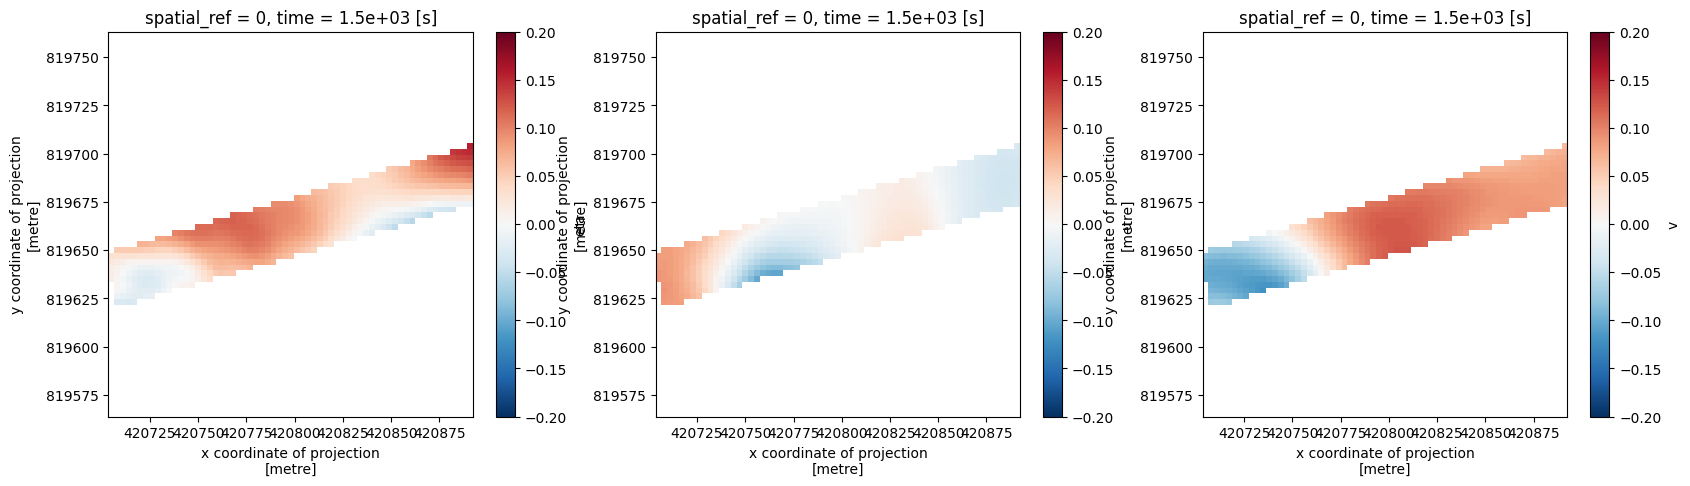

In [76]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(131)
dset.eta.isel(time=0).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.axis("equal")

ax = fig.add_subplot(132)
dset.u.isel(time=0).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.axis("equal")

ax = fig.add_subplot(133)
dset.v.isel(time=0).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.axis("equal");

### Points example

In [77]:
points = geopandas.GeoSeries(
    MultiPoint(
        [
            (176.910297, -39.474199),
            (176.912532, -39.473656),
            (176.914437, -39.4730982),
            (176.916403, -39.472642),
        ]
    )
)
dset = query_dataset(datasources[0], geom=points)
dset

<xarray.Dataset>
Dimensions:      (yall: 1801, xall: 2285, point: 4, time: 3602)
Coordinates:
    spatial_ref  int64 ...
  * time         (time) float64 1.5e+03 1.501e+03 ... 5.1e+03 5.101e+03
  * xall         (xall) float64 4.239e+05 4.238e+05 ... 4.17e+05 4.17e+05
  * yall         (yall) float64 8.24e+05 8.24e+05 ... 8.186e+05 8.186e+05
Dimensions without coordinates: point
Data variables:
    dep.out      (yall, xall, point) float64 dask.array<chunksize=(1801, 2285, 4), meta=np.ndarray>
    eta          (time, point) float64 dask.array<chunksize=(512, 4), meta=np.ndarray>
    u            (time, point) float64 dask.array<chunksize=(512, 4), meta=np.ndarray>
    v            (time, point) float64 dask.array<chunksize=(512, 4), meta=np.ndarray>
    x            (point) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    y            (point) float64 dask.array<chunksize=(4,), meta=np.ndarray>

(420339.40570920025, 420917.85020863474, 819575.7300968668, 819764.3448073122)

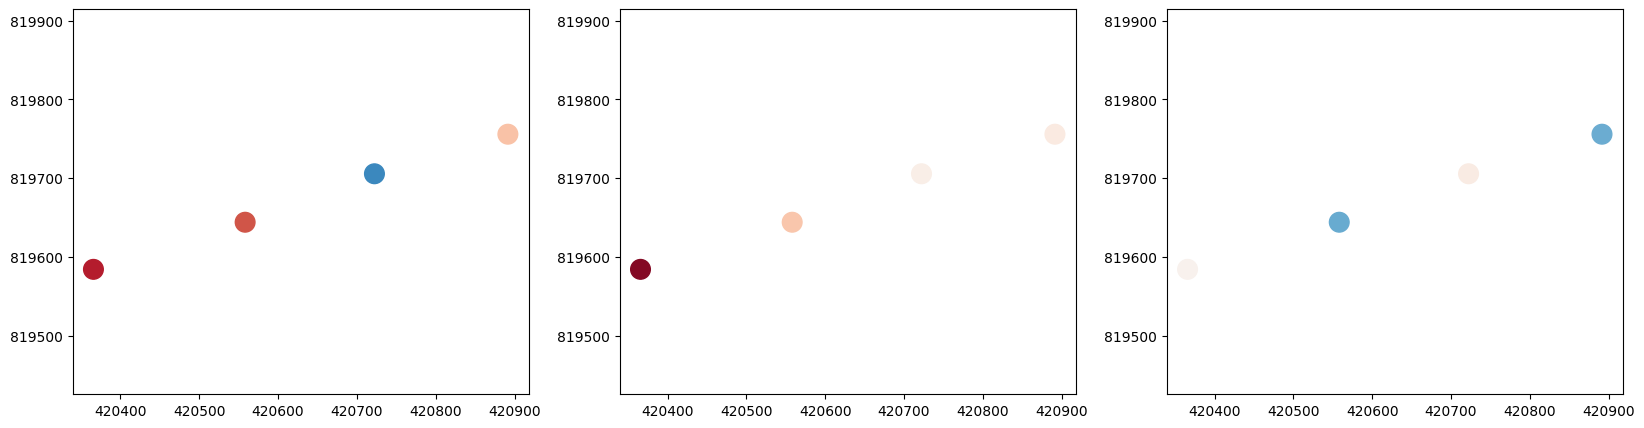

In [78]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(131)
ax.scatter(dset.x, dset.y, s=200, c=dset.eta.isel(time=0), vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.axis("equal")

ax = fig.add_subplot(132)
ax.scatter(dset.x, dset.y, s=200, c=dset.u.isel(time=0), vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.axis("equal")

ax = fig.add_subplot(133)
ax.scatter(dset.x, dset.y, s=200, c=dset.v.isel(time=0), vmin=-0.2, vmax=0.2, cmap="RdBu_r")
plt.axis("equal")

### Get and save points from all events

Queries get cached in the Datamesh gateway so rerunning the same query should be faster

In [88]:
for datasource in tqdm(datasources):
    dset = query_dataset(datasource, geom=points)
    dset.to_netcdf(f"{datasource}.nc")

100%|██████████| 20/20 [14:13<00:00, 42.68s/it]
